In [1]:
!lamin load vals/scrna

✅ wrote new records from public sources.yaml to /home/vale/.lamin/bionty/versions/sources_local.yaml!

if you see this message repeatedly, run: bt.reset_sources()
💡 loaded instance: vals/scrna


In [49]:
import lamindb as ln
import lnschema_bionty as lb
import numpy as np
from openai import OpenAI
import pandas as pd
import plotnine as p
import pymde
from tqdm import tqdm

ln.settings.verbosity = "warning"

In [3]:
client = OpenAI()

In [4]:
ln.Artifact.filter().all().count()

236

In [5]:
query = ln.Artifact.filter().all()

In [6]:
obs_samples = []
for tmp_ in tqdm(query.iterator()):
    try: 
        a_ = tmp_.backed()
        n_ = min(a_.shape[0], 100)
        obs_sample = a_.obs.sample(n_, replace = True)
        obs_samples += [obs_sample]
    except AttributeError as e:
        continue

236it [00:36,  6.55it/s]


In [7]:
text_obs_samples = []
for o_ in obs_samples:
    o_ = o_.select_dtypes(exclude = 'number')
    if o_.shape[1] > 0:
        text_obs_samples += [o_]

In [8]:
all_metadata = []
for o_ in text_obs_samples:
    for _, r_ in o_.reset_index().iterrows():
        js_ = r_.to_json()
        all_metadata += [js_]

In [53]:
len(text_obs_samples)

58

In [54]:
dataset_idx = []
for i_, o_ in enumerate(text_obs_samples):
    for _, r_ in o_.reset_index().iterrows():
        dataset_idx += [i_]

In [9]:
len(all_metadata)

5760

In [10]:
all_metadata[:5]

['{"index":"GCGAGAAGTCCATCCT-15","patient_assignment":"U5","tissue_assignment":"R","disease_assignment":"diseased","celltype":"T"}',
 '{"index":"AAGCCGCTCGAGCCCA-20","patient_assignment":"C4","tissue_assignment":"PBMC","disease_assignment":"healthy","celltype":"T"}',
 '{"index":"ACTTACTAGAGACTAT-17","patient_assignment":"U6","tissue_assignment":"R","disease_assignment":"diseased","celltype":"T"}',
 '{"index":"CGGCTAGCAGGTCCAC-8","patient_assignment":"U2","tissue_assignment":"PBMC","disease_assignment":"diseased","celltype":"T"}',
 '{"index":"CGCGTTTGTGCAACGA-11","patient_assignment":"U3","tissue_assignment":"R","disease_assignment":"diseased","celltype":"B"}']

In [29]:
responses = []
for chunk in tqdm(np.array_split(all_metadata, 100)):
    response = client.embeddings.create(
        input = list(chunk),
        model = 'text-embedding-3-small'
    )
    responses += [response]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


In [30]:
embeddings_list = []
for response in responses:
    embeddings = np.array([d.embedding for d in response.data])
    embeddings_list += [embeddings]

In [40]:
embeddings = np.vstack(embeddings_list)

In [33]:
token_dist = [response.usage.total_tokens for response in responses]

<Axes: >

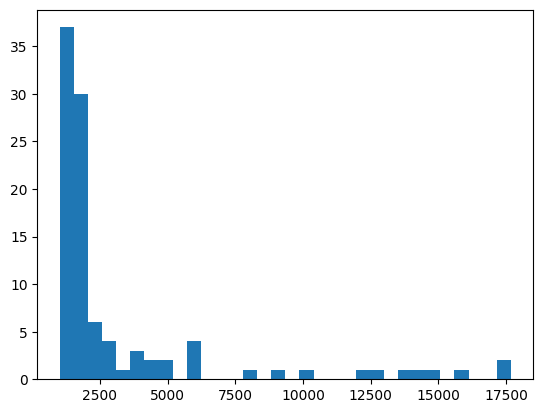

In [39]:
pd.Series(token_dist).hist(bins = 32, grid = False)

In [42]:
embeddings.shape

(5760, 1536)

In [91]:
embeddings_df = pd.DataFrame(embeddings, index = all_metadata)

In [92]:
embeddings_df.to_csv('vals_all_metadata_embeddings.tsv', sep = '\t')

In [93]:
ls -lh

total 182M
-rwxrwxrwx 1 vale vale  90K Jan 29 19:55 '240124 LaminDB metadata.ipynb'*
-rwxrwxrwx 1 vale vale  12K Jan 29 20:30 '240129 cellxgene_census metadata.ipynb'*
-rwxrwxrwx 2 vale vale 548K Jan 29 22:46 '240129 vals metadata examples.ipynb'*
-rwxrwxrwx 1 vale vale 181M Jan 29 22:46  vals_all_metadata_embeddings.tsv*


In [45]:
mde = pymde.preserve_neighbors(embeddings).embed()

Jan 29 10:23:03 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jan 29 10:23:03 PM: The following items have duplicates [  73 1290 1379 1434 1492 1835 1885 1895 2132 2164 2202 2524 2573 2647
 2661 2760 2761 2931 2947 3048 3082 3083 3155 3252 3336 3387 3430 3442
 3447 3581 3621 3674 3726 3731 3767 3790 3840 3845 3866 3878 3919 4044
 4050 4051 4090 4245 5401 5413 5432 5448 5456 5459]


In [47]:
mde_a = mde.numpy()
mdata = pd.DataFrame(mde_a, index = all_metadata, columns = ['mde_1', 'mde_2'])

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig1.png
2024-01-29 23:34:42,137:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-01-29 23:34:42,828:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


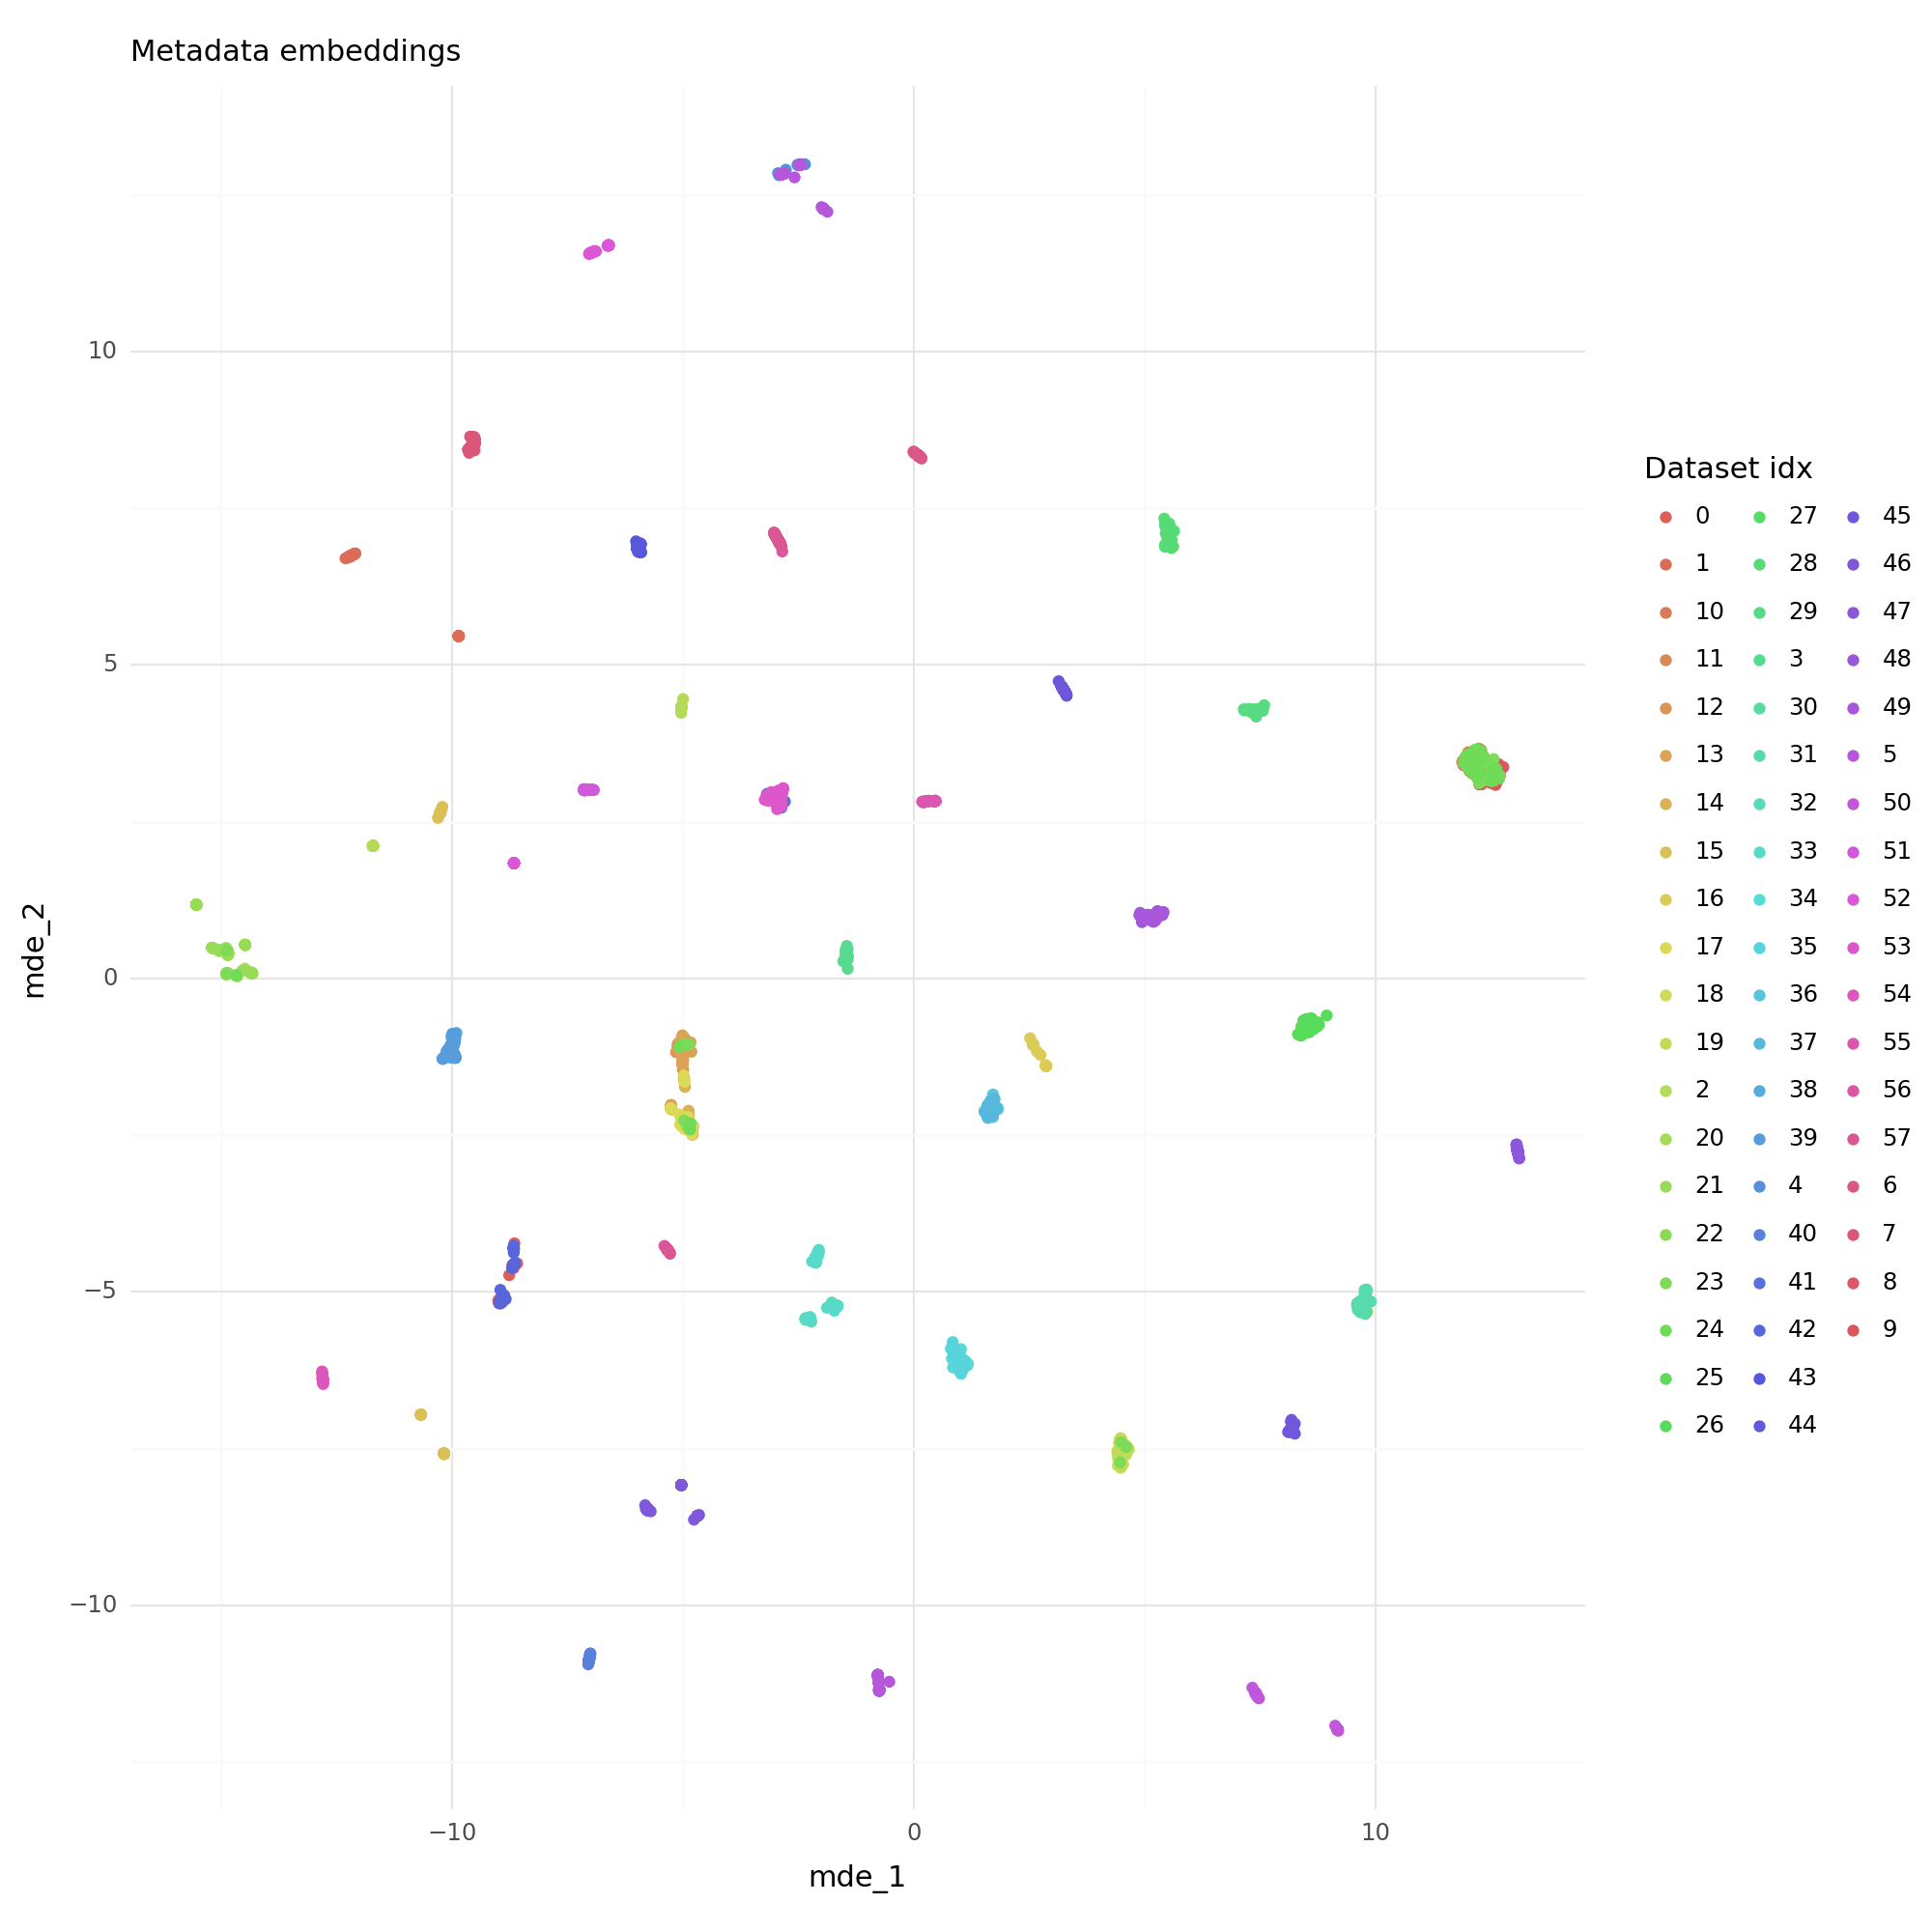

In [199]:
p.options.figure_size = 10, 10

p_ = (
    p.ggplot(mdata, p.aes(x = 'mde_1', y = 'mde_2', color = 'data_idx.astype(str)'))
    + p.geom_point()
    + p.theme_minimal()
    + p.labs(color = 'Dataset idx', subtitle = 'Metadata embeddings')
)

p_.save('fig1.png')

print(p_)

In [59]:
mdata['data_idx'] = dataset_idx

In [74]:
dataset_examples = mdata.reset_index().groupby(['data_idx']).sample(1)
dataset_examples['index'] = dataset_examples['index'].str.replace(',', ', \n')

2024-01-29 22:34:48,723:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


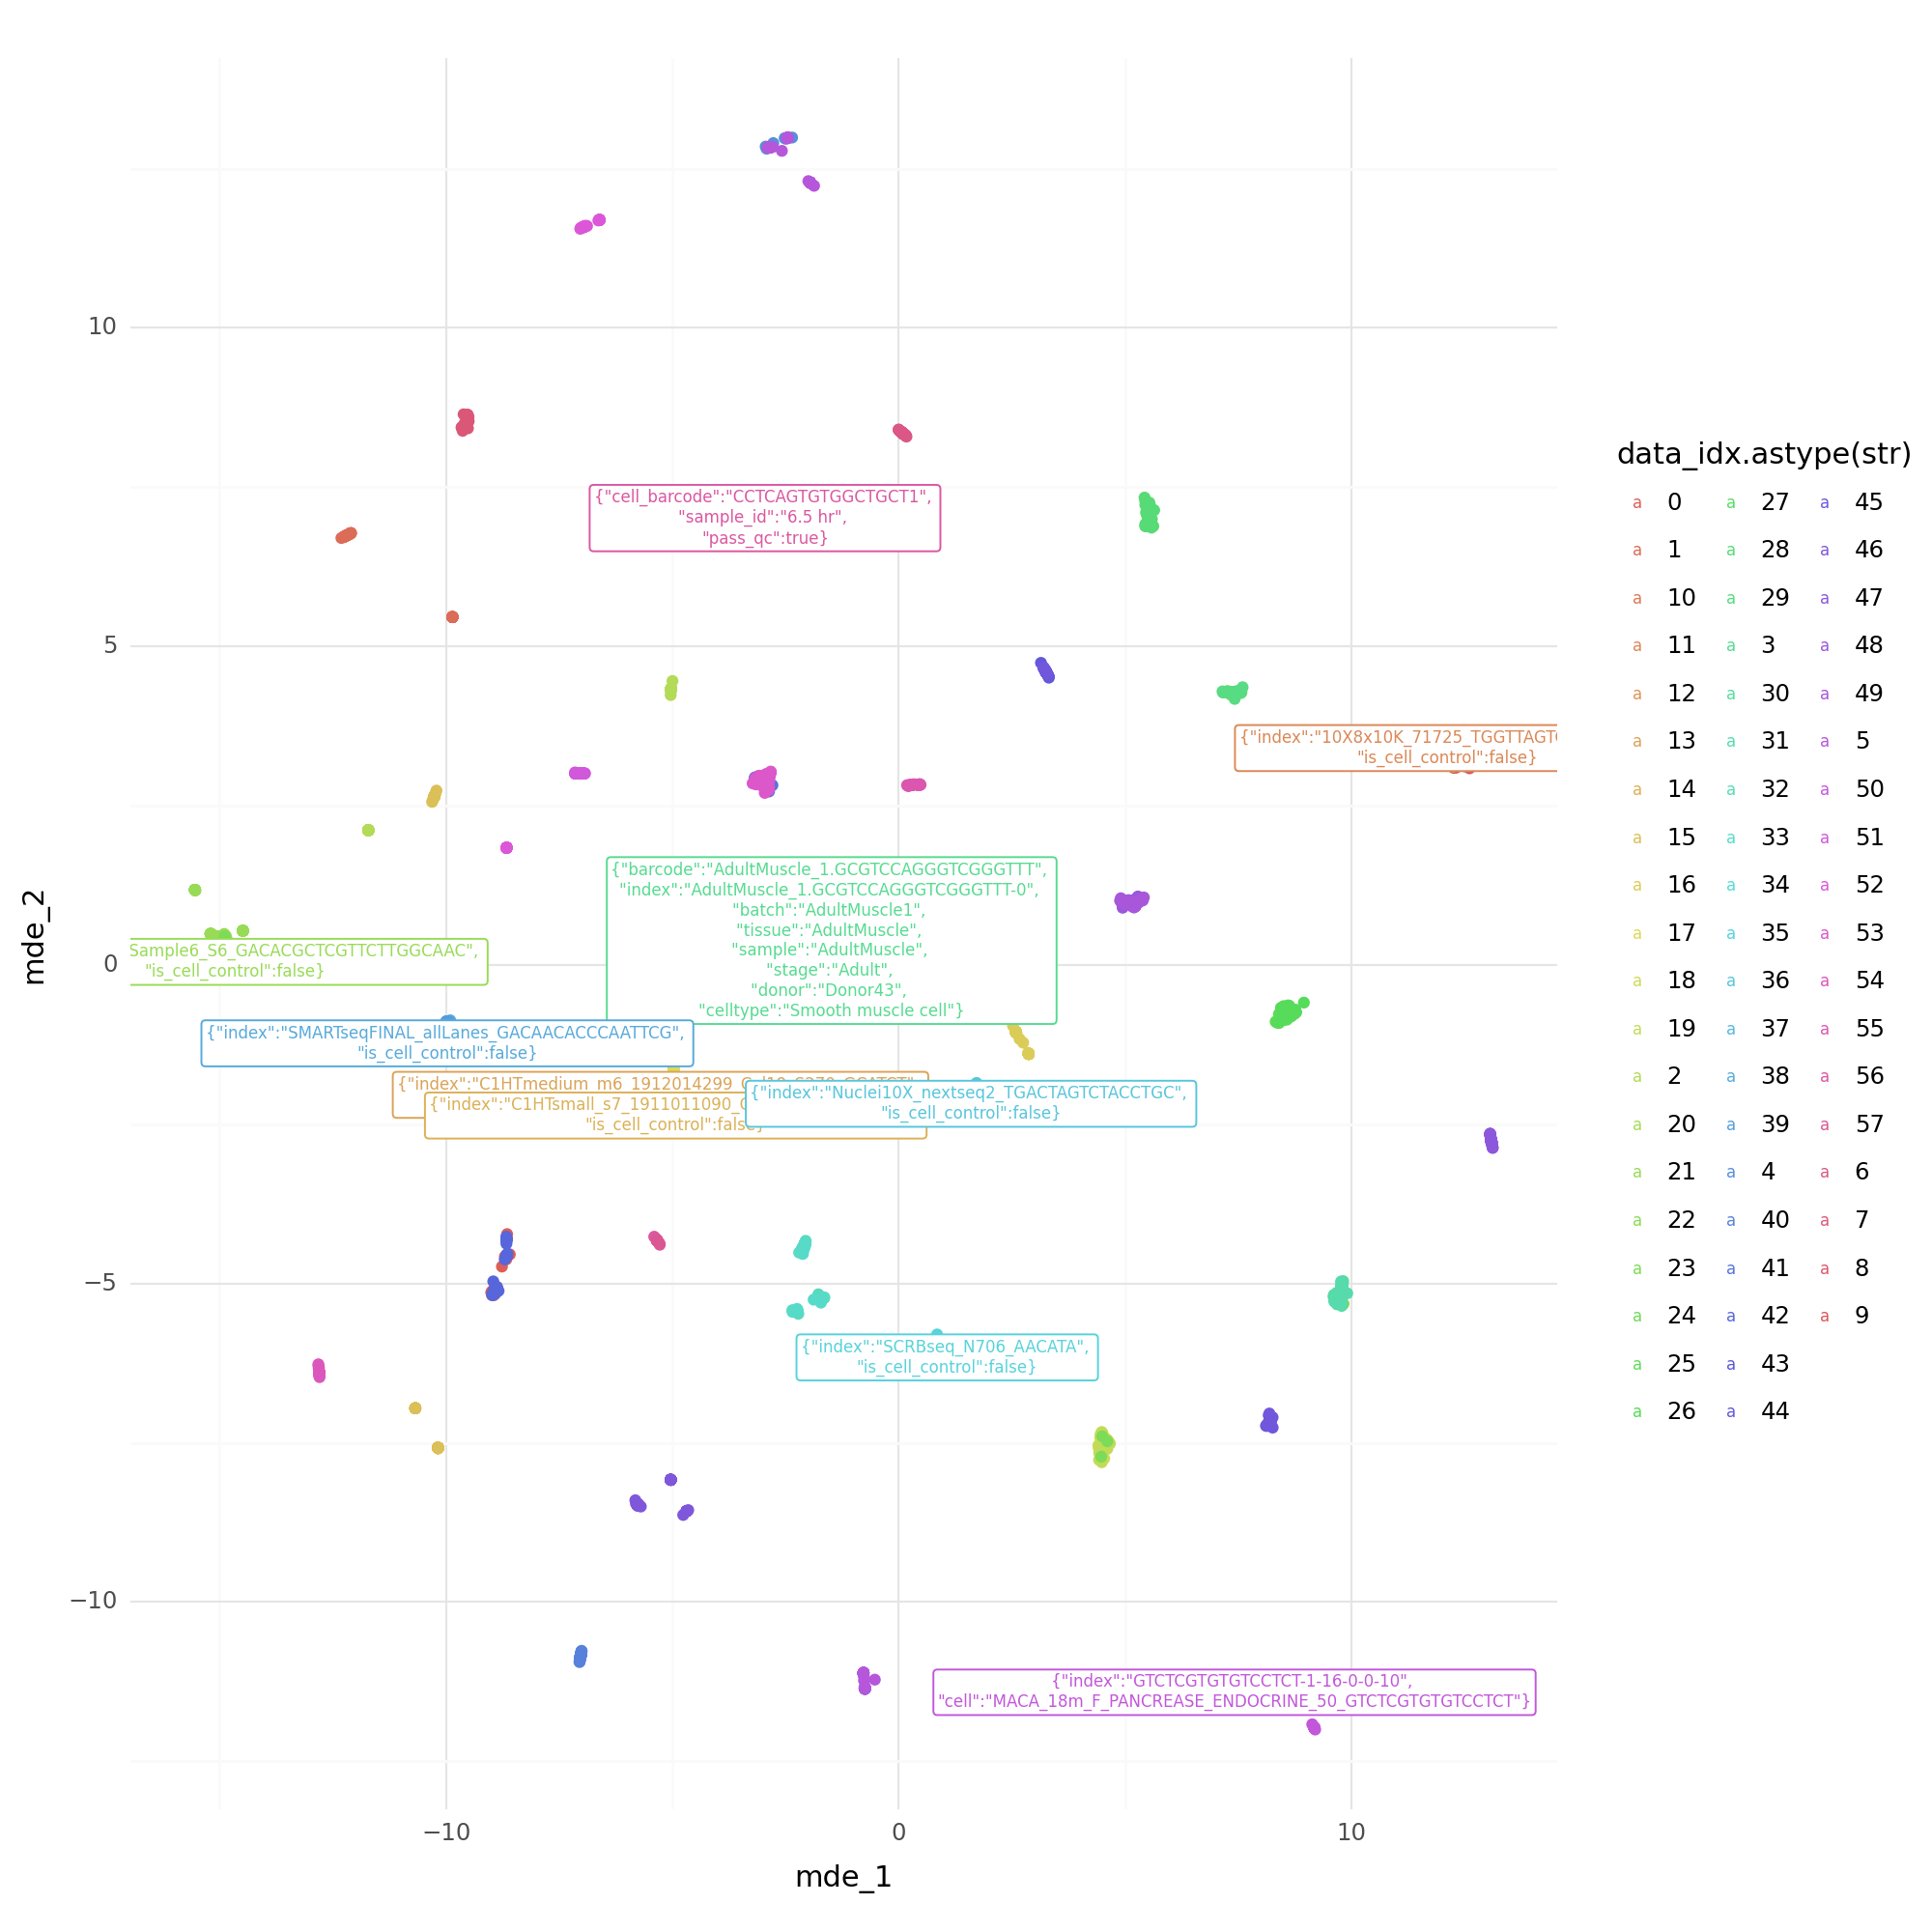

<Figure Size: (1000 x 1000)>

In [77]:
p.options.figure_size = 10, 10

(
    p.ggplot(mdata, p.aes(x = 'mde_1', y = 'mde_2', color = 'data_idx.astype(str)'))
    + p.geom_point()
    + p.geom_label(p.aes(label = 'index'), data = dataset_examples.sample(10), size = 6)
    + p.theme_minimal()
)

In [206]:
mdata.groupby(['data_idx']).sample(1).index

Index(['{"index":"CTGAAACAGAATAGGG-11","patient_assignment":"U3","tissue_assignment":"R","disease_assignment":"diseased","celltype":"B"}',
       '{"index":"N52.LPA1b.CCCAGTTTCTGGTTCC-2","Cluster":"Plasma","Subject":"N52","Health":"Non-inflamed","Location":"LP","Sample":"N52.LPA1b","batch":"2"}',
       '{"barcode":"AAGACCTCATAACCTG-1","hash.ID":"T1-CD19pos"}',
       '{"barcode":"AdultLung_3.ATGCTTTCAAAGTTGGAC4","index":"AdultLung_3.ATGCTTTCAAAGTTGGAC4-1","batch":"AdultLung3","tissue":"AdultLung","sample":"AdultLung","stage":"Adult","donor":"Donor42","celltype":"M2 Macrophage"}',
       '{"barcodekey":"02-P248880-S086-R01-AACACACTCCGCGATG","method":"nuclei","doublet":false,"predicted_celltype":"ciliated","compartment":"epithelial","Cluster":"Ciliated","SubCluster":"Ciliated","Viral+":false,"leiden_res_2":"16","leiden_res_1.3":"11","donor":"D5","disease":"COVID-19"}',
       '{"barcodekey":"02-P248880-S086-R01-CAATACGCAGTTCTAG","method":"nuclei","doublet":false,"predicted_celltype":"ci

In [84]:
dataset_examples.query('index.str.contains("PBMC")')

,index,mde_1,mde_2,data_idx
90,"{""index"":""TGTGTTTTCAAAGTAG-8"", \n""patient_assi...",-8.947953,-5.140604,0
636,"{""barcode"":""TGGCCAGCAATGGAAT-1"", \n""sample"":""G...",0.108137,8.334554,6
707,"{""barcode"":""GAATGAATCATTATCC-1"", \n""sample"":""G...",-9.633403,8.384703,7
4239,"{""index"":""GGTGAAGAGGAATCGC-10"", \n""patient_ass...",-8.957133,-4.967382,42
4432,"{""index"":""d13_PGW8_AAGACCTGTGCGGTAA"", \n""Meta ...",3.253035,4.596483,44
4545,"{""index"":""d08_200177A_S4_CATTCGCTCAATAAGG"", \n...",8.189251,-7.165742,45


In [86]:
mdata.query('data_idx == 0')

,mde_1,mde_2,data_idx
"{""index"":""GCGAGAAGTCCATCCT-15"",""patient_assignment"":""U5"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.662330,-4.567043,0
"{""index"":""AAGCCGCTCGAGCCCA-20"",""patient_assignment"":""C4"",""tissue_assignment"":""PBMC"",""disease_assignment"":""healthy"",""celltype"":""T""}",-8.922177,-5.107306,0
"{""index"":""ACTTACTAGAGACTAT-17"",""patient_assignment"":""U6"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.665408,-4.569092,0
"{""index"":""CGGCTAGCAGGTCCAC-8"",""patient_assignment"":""U2"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.916114,-5.101004,0
"{""index"":""CGCGTTTGTGCAACGA-11"",""patient_assignment"":""U3"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""B""}",-8.662301,-4.566854,0
...,...,...,...
"{""index"":""GGGCATCAGCGTTTAC-18"",""patient_assignment"":""U7"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.922520,-5.106688,0
"{""index"":""CGTGAGCAGCCACGTC-23"",""patient_assignment"":""C5"",""tissue_assignment"":""R"",""disease_assignment"":""healthy"",""celltype"":""B""}",-8.666028,-4.305391,0
"{""index"":""GACTGCGTCCTCTAGC-10"",""patient_assignment"":""U3"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.924070,-5.085955,0
"{""index"":""GGGAATGTCCACGTGG-30"",""patient_assignment"":""C9"",""tissue_assignment"":""PBMC"",""disease_assignment"":""healthy"",""celltype"":""T""}",-8.945125,-5.184756,0


In [95]:
data0 = mdata.query('data_idx == 0')

In [99]:
import json

In [122]:
data0 = pd.concat((data0, (pd.DataFrame(list(data0.index.map(json.loads)), index = data0.index).drop(['index'], axis = 1))), axis = 1)

In [124]:
data0

,mde_1,mde_2,data_idx,patient_assignment,tissue_assignment,disease_assignment,celltype
"{""index"":""GCGAGAAGTCCATCCT-15"",""patient_assignment"":""U5"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.662330,-4.567043,0,U5,R,diseased,T
"{""index"":""AAGCCGCTCGAGCCCA-20"",""patient_assignment"":""C4"",""tissue_assignment"":""PBMC"",""disease_assignment"":""healthy"",""celltype"":""T""}",-8.922177,-5.107306,0,C4,PBMC,healthy,T
"{""index"":""ACTTACTAGAGACTAT-17"",""patient_assignment"":""U6"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.665408,-4.569092,0,U6,R,diseased,T
"{""index"":""CGGCTAGCAGGTCCAC-8"",""patient_assignment"":""U2"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.916114,-5.101004,0,U2,PBMC,diseased,T
"{""index"":""CGCGTTTGTGCAACGA-11"",""patient_assignment"":""U3"",""tissue_assignment"":""R"",""disease_assignment"":""diseased"",""celltype"":""B""}",-8.662301,-4.566854,0,U3,R,diseased,B
...,...,...,...,...,...,...,...
"{""index"":""GGGCATCAGCGTTTAC-18"",""patient_assignment"":""U7"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.922520,-5.106688,0,U7,PBMC,diseased,T
"{""index"":""CGTGAGCAGCCACGTC-23"",""patient_assignment"":""C5"",""tissue_assignment"":""R"",""disease_assignment"":""healthy"",""celltype"":""B""}",-8.666028,-4.305391,0,C5,R,healthy,B
"{""index"":""GACTGCGTCCTCTAGC-10"",""patient_assignment"":""U3"",""tissue_assignment"":""PBMC"",""disease_assignment"":""diseased"",""celltype"":""T""}",-8.924070,-5.085955,0,U3,PBMC,diseased,T
"{""index"":""GGGAATGTCCACGTGG-30"",""patient_assignment"":""C9"",""tissue_assignment"":""PBMC"",""disease_assignment"":""healthy"",""celltype"":""T""}",-8.945125,-5.184756,0,C9,PBMC,healthy,T


/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 6 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig2.png
2024-01-29 23:35:17,061:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-01-29 23:35:17,237:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


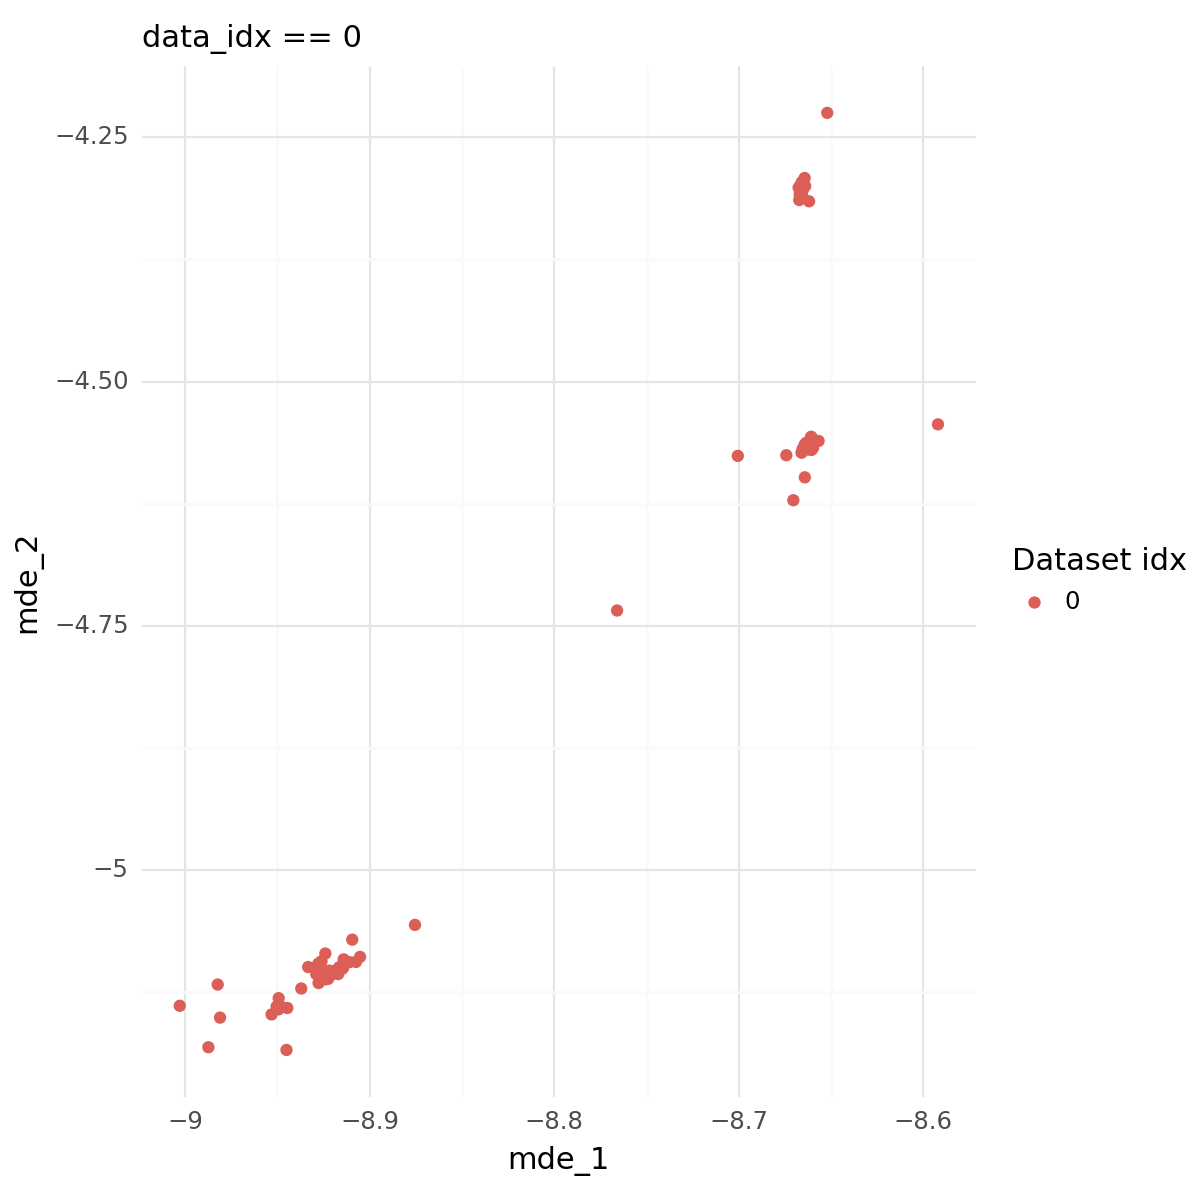

In [200]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(data0, p.aes(x = 'mde_1', y = 'mde_2', color = 'data_idx.astype(str)'))
    + p.geom_point()
    + p.theme_minimal()
    + p.labs(color = 'Dataset idx', subtitle = 'data_idx == 0')
)

p_.save('fig2.png')

print(p_)

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 6 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig3.png
2024-01-29 23:35:47,517:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-01-29 23:35:47,715:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


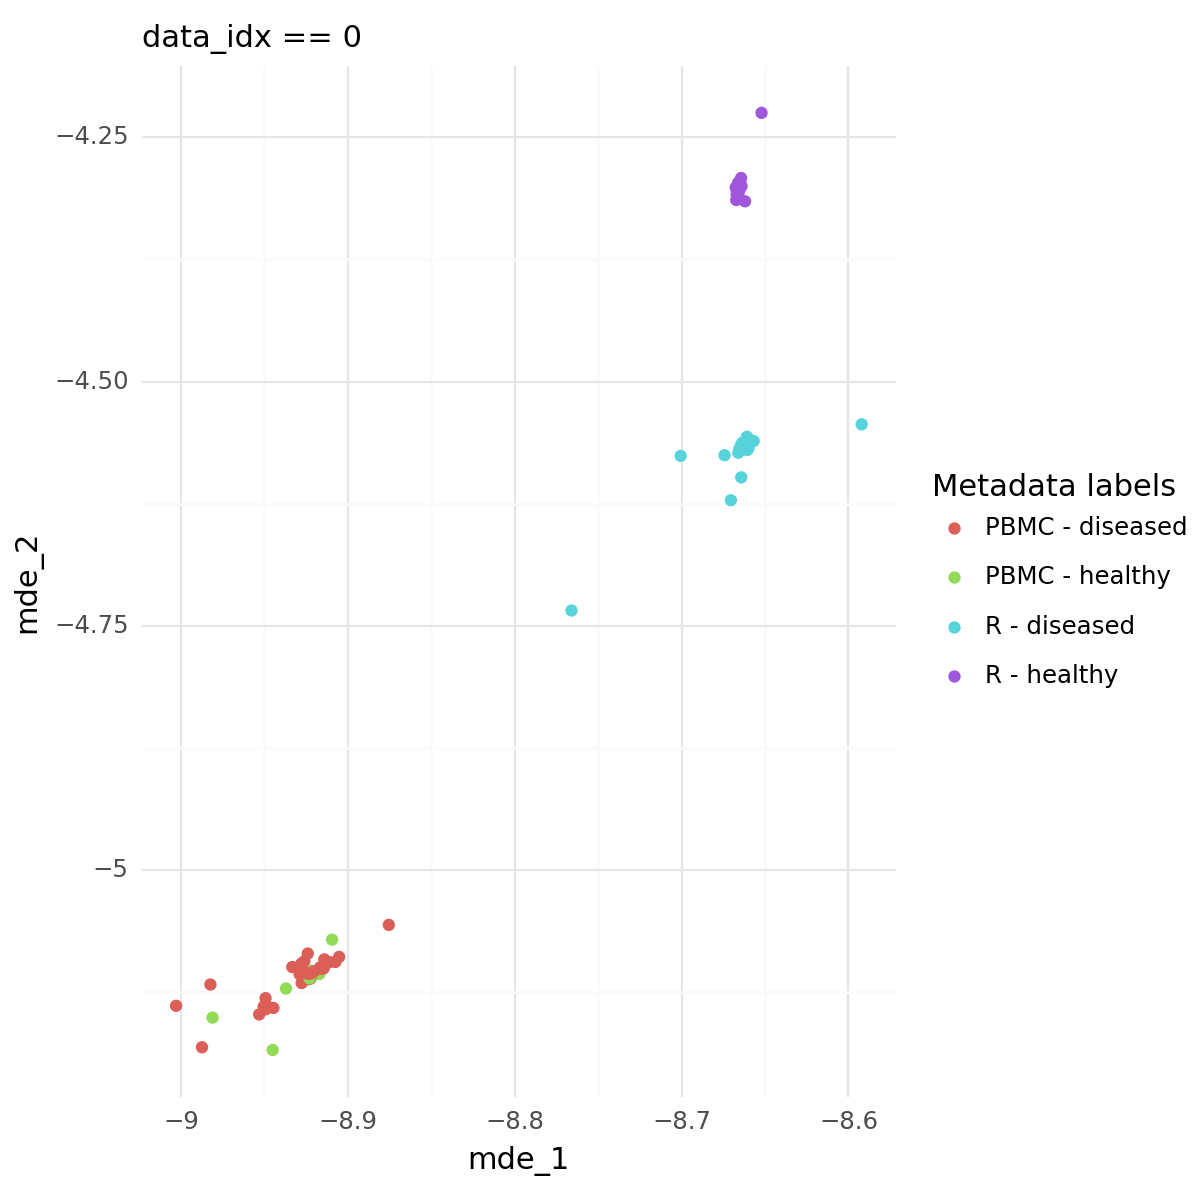

In [201]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(data0, p.aes(x = 'mde_1', y = 'mde_2', color = 'tissue_assignment + " - " + disease_assignment'))
    + p.geom_point()
    + p.theme_minimal()
    + p.labs(color = 'Metadata labels', subtitle = 'data_idx == 0')
)

p_.save('fig3.png')

print(p_)

In [134]:
response = client.embeddings.create(
    input = 'Blood',
    model = 'text-embedding-3-small'
)

In [142]:
blood_vector = np.array(response.data[0].embedding)

In [158]:
blood_vector = blood_vector.reshape(blood_vector.shape[0], 1)

In [147]:
import sklearn

In [151]:
embeddings_df.loc[data0.index].values

array([[-0.00488241, -0.00239688,  0.03701697, ...,  0.02084864,
        -0.00770832, -0.01126819],
       [ 0.00110081, -0.01681308,  0.04836215, ...,  0.00478218,
        -0.01414656, -0.01237122],
       [-0.00762819, -0.00154418,  0.03619151, ...,  0.02874697,
        -0.01338464, -0.00867353],
       ...,
       [-0.01038833, -0.00105154,  0.04607   , ...,  0.01939344,
        -0.00323577, -0.01213854],
       [ 0.00036304, -0.0073593 ,  0.04499319, ...,  0.011887  ,
        -0.00485061, -0.00256901],
       [ 0.00434181, -0.01406383,  0.04443558, ...,  0.02050337,
        -0.01127615, -0.00296017]])

In [182]:
emb0 = embeddings_df.iloc[np.array(dataset_idx) == 0].copy()

In [183]:
blood_distance = sklearn.metrics.pairwise_distances(blood_vector.T, emb0.values, metric = 'cosine')

In [189]:
data0['blood_distance'] = blood_distance[0]

/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 6 in image.
/home/vale/mambaforge/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: fig4.png
2024-01-29 23:37:45,569:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-01-29 23:37:45,742:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


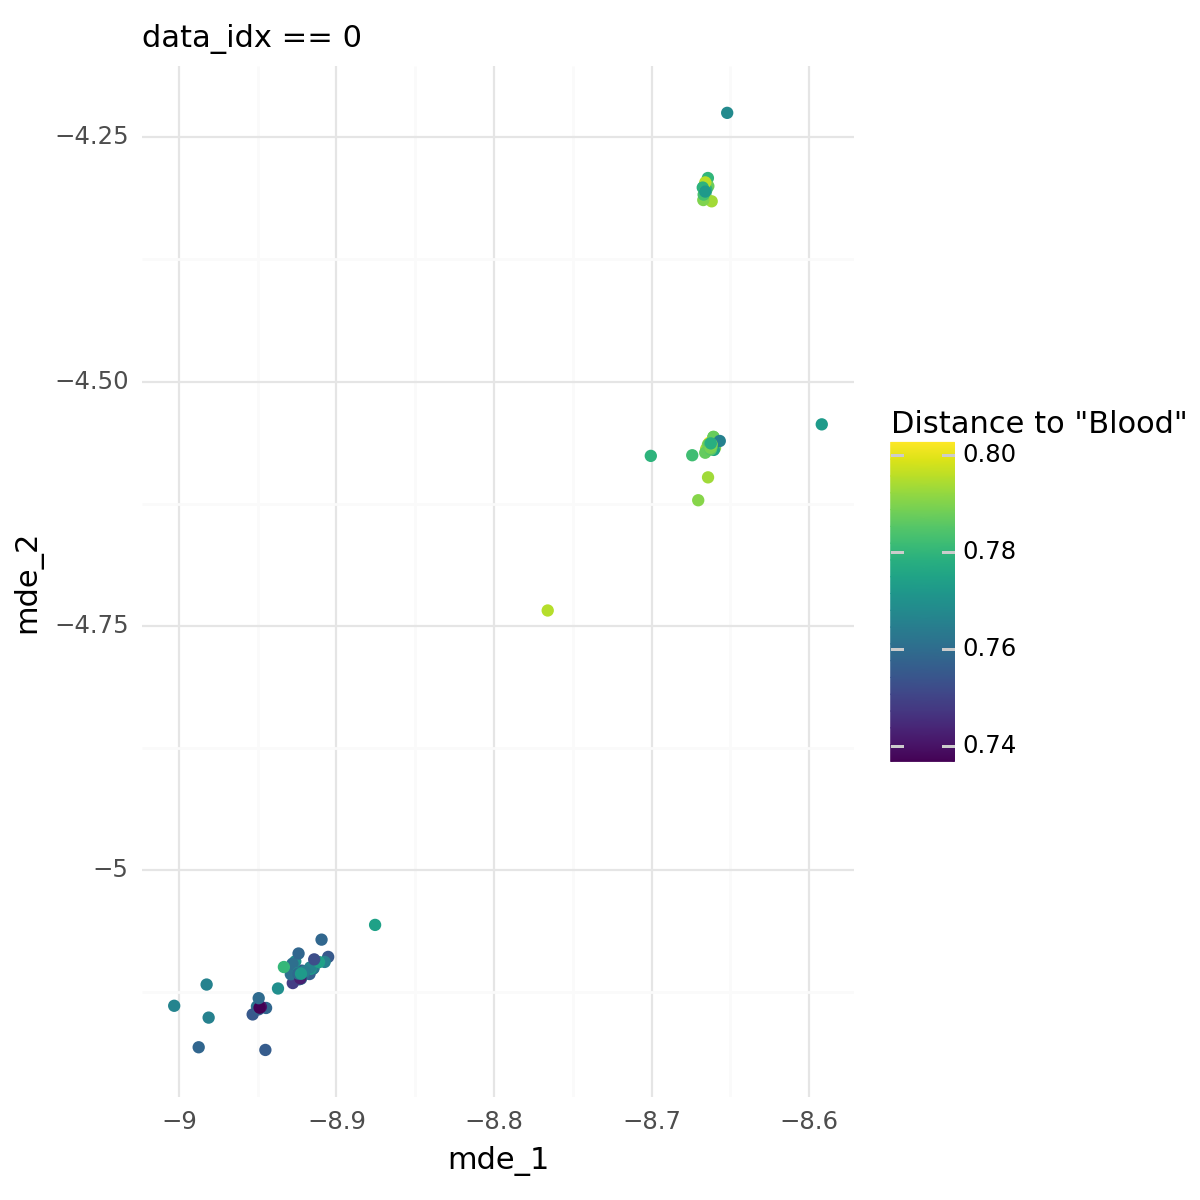

In [203]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(data0, p.aes(x = 'mde_1', y = 'mde_2', color = 'blood_distance'))
    + p.geom_point()
    + p.theme_minimal()
    + p.labs(color = 'Distance to "Blood"', subtitle = 'data_idx == 0')
)

p_.save('fig4.png')

print(p_)